<p align = "center">
<img src = "https://raw.githubusercontent.com/kirilvino/Swan-Project-Team-7/refs/heads/main/swan_logo.jpg" 
     width = 300px, height=225px/ alt="Right aligned" style="float: right; margin: 0 0 15px 15px;">

# Swan Teleco: Customer Retention Analysis
## <i> by Team Churners </i>
### Exploration and prediction of the Swan database for churning of customers.
This notebook includes:

<b> 1. Exploratory Data Analysis </b>

Checks, null handling, cleaning & visuals

<b> 2. Modelling Churn Risk </b>

FE, scaling, training different models for comparison, calculating and comparing metrics 

<b> 3. Extracting the customer lists most likely to churn </b>

Using the best model extracting a list of all/top 500 most likely to churn customers

## 0. Imports

In [1]:
# Import statements and set up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch

# Import machine learning related libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,  roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Set the visual style for plots
two_palette=['#2c3e6c', '#b0c4de']
three_palette = ['#2c3e6c', '#b0c4de', '#98A8B6']
five_palette = ['#2c3e6c', '#b0c4de', '#98A8B6', '#7F8C8D', '#2A2A2A']

## 1. Exploratory Data 

### 1.1. Initial Checks

In [2]:
df = pd.read_csv("Project_Data.csv")
print("Data Shape:", df.shape)
print("Data Nulls:\n", df.isna().sum())

Data Shape: (7043, 31)
Data Nulls:
 CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64


Investigation into the huge number of nulls for 'Churn Reason' showed that these nulls are solely for the reason 'when the customer has not churned', which is completely logical and suggests the data is still consistent even if it has these nulls.

In [3]:
# The churn value is 0 where the Churn Reason is null which makes sense
nullReason = df[df['Churn Reason'].isna()].copy()
nullReason['Churn Value'].value_counts()

Churn Value
0    5174
Name: count, dtype: int64

### 1.2. Renaming columns
Rename the variables to more standard coding practices.

In [4]:
# Rename columns at this point for consistency
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Churn Label': 'churn_flag',
    'Churn Value': 'churn_value',
    'Churn Reason': 'churn_reason',
    'Tenure Months': 'tenure_months',
    'Monthly Charges': 'monthly_charges',
    'Total Charges': 'total_charges'
})

### 1.3. Demographics of churners

- Explore relationships between churners and different features within the dataset through visualisations.
- Prior to this, normalise the values within the graph to get a percentage of the total number of people who did or didn't churn. Here is the mathematical calculation for context:

   $\text{Percentage(\%) = \text{Count of entries with flag in that column} / \text{Count of total entries with flag}}$

### i. Gender, Senior Citizen, Partner & Dependents

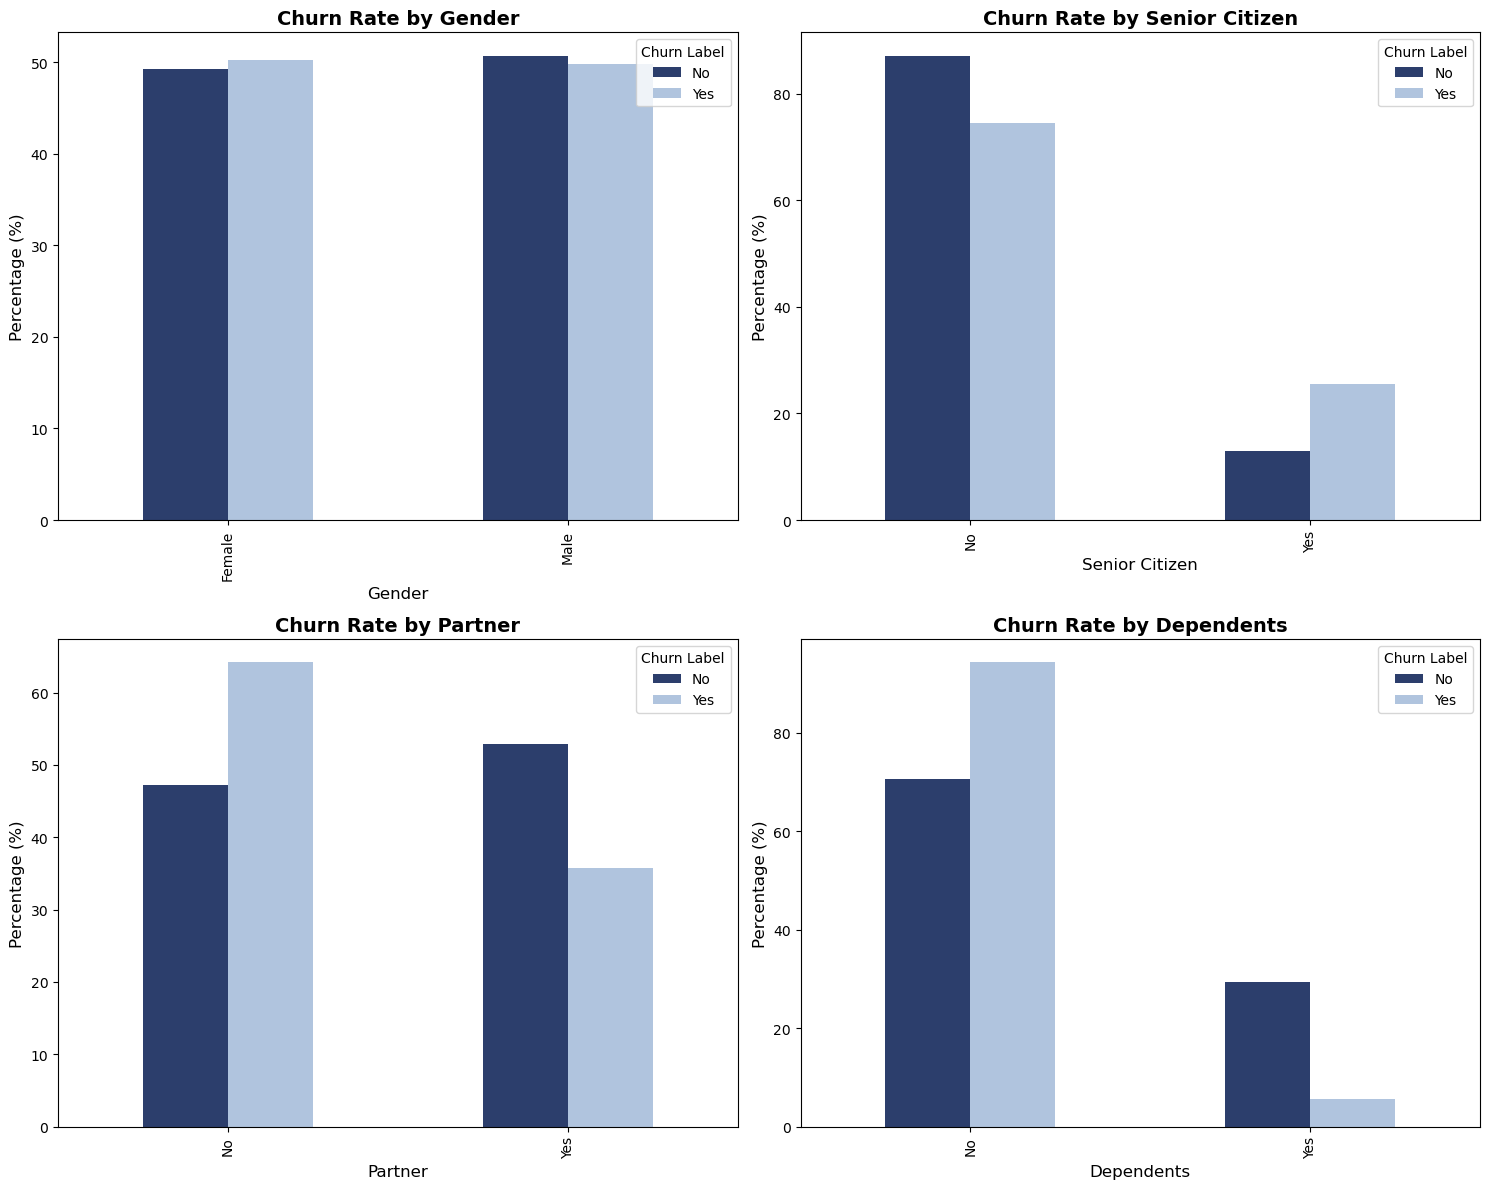

In [5]:
# Demographic Analysis
columns = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

From the above graphs, we make the following brief insights:
- *Gender* does not seem to have an effect on someone churning.
- *Senior citizens* have a higher chance of churning.
- People with *partners* or *dependents* exhibit much stronger loyalty.

### ii. Review how different contractual/financial obligations affect on churning of customers.

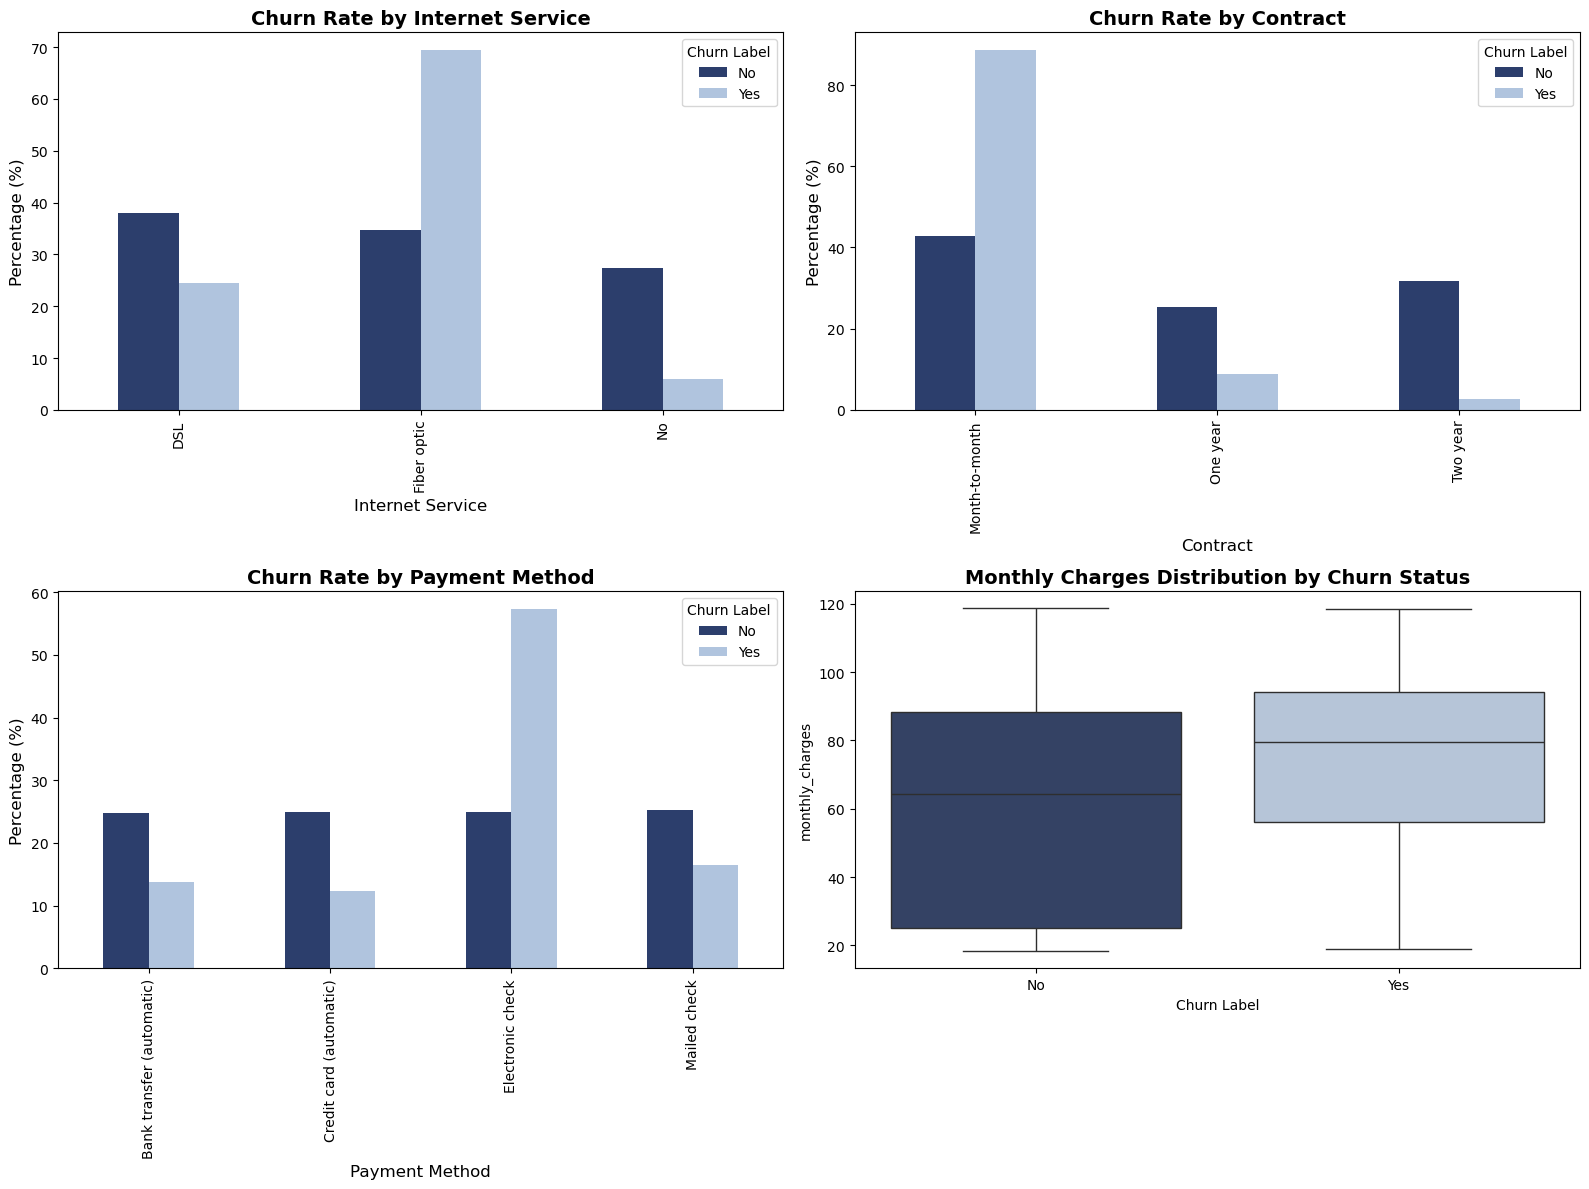

In [30]:
# Payment Method, Internet Service & Contract type Analysis
columns = ['Internet Service', 'Contract', 'Payment Method']
# Service Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100
    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

sns.boxplot(data=df, x='churn_flag', y='monthly_charges', ax=axes[3], order=['No', 'Yes'], palette=two_palette[::-1], hue = 'churn_flag')
axes[3].set_title('Monthly Charges Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Churn Label')

plt.tight_layout()
plt.show()

The following are the highest churn rates for their respective categories:
- *Fiber optic*
- *Month to month*
- *Electronic checks*

Additionally, churned customers have on average higher *monthly charges*

### iii. Add-ons

It is also important to review add-ons offered by Swan Teleco, specific to the customers who opt for *Internet Service scheme*. This will help to review which of these add-ons can help reduce churning.

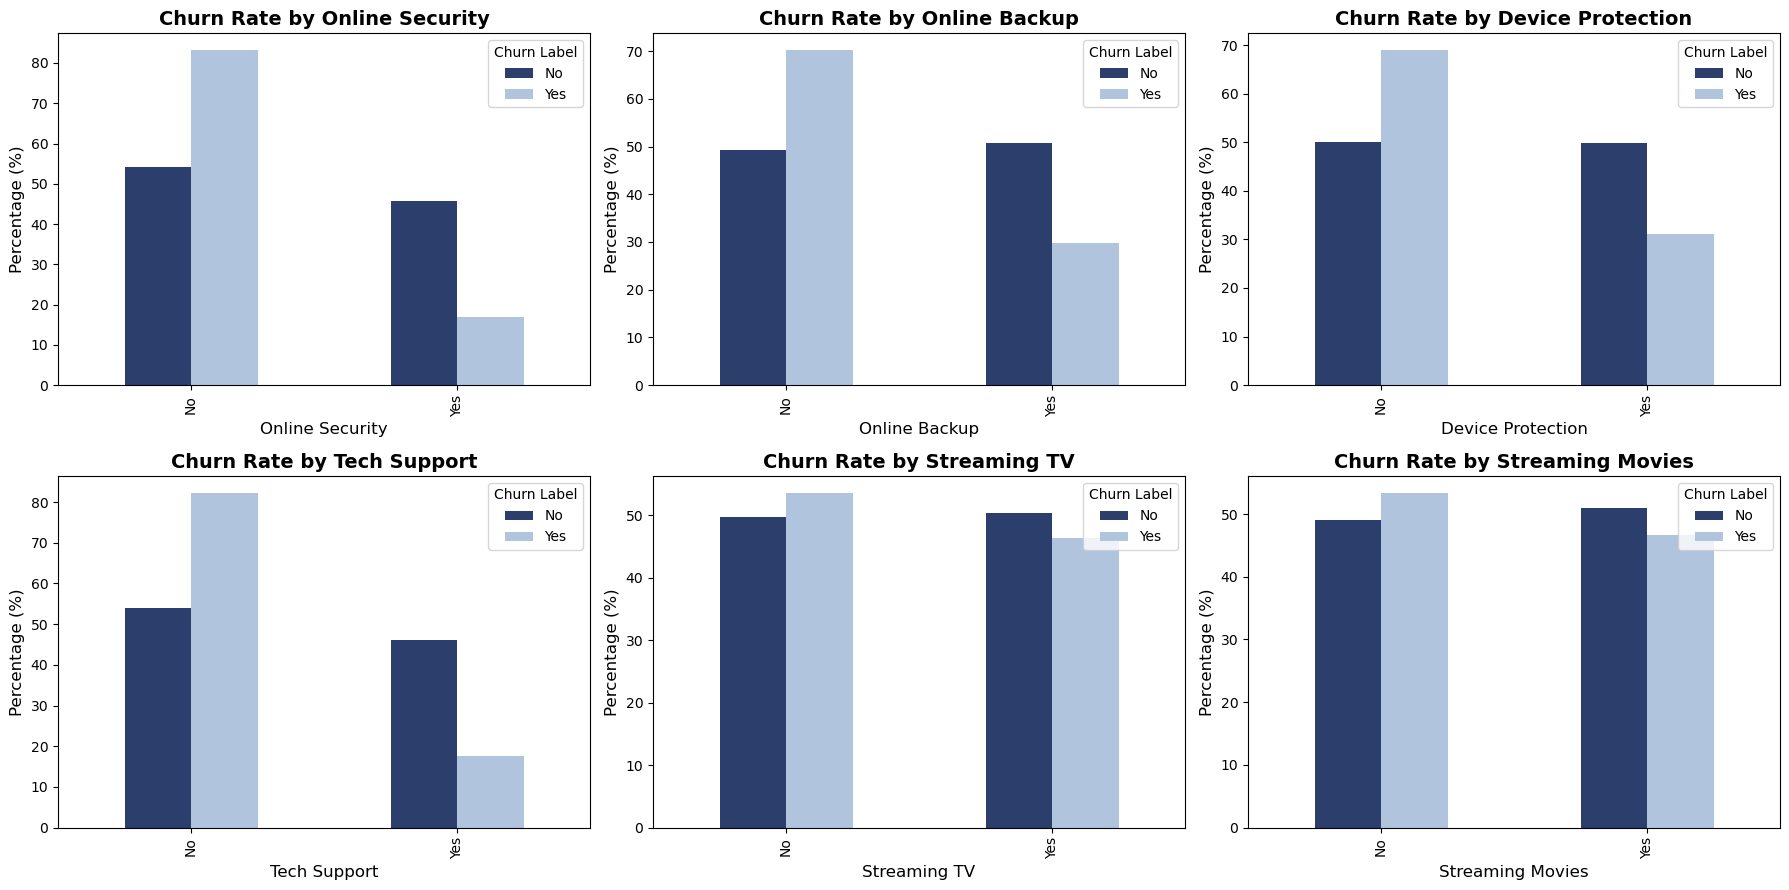

In [7]:
# Add on columns to analyze
columns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 'Streaming Movies']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
axes = axes.flatten()

# Remove rows where InternetService is 'No'
df_internet = df[df['Internet Service'] != 'No']

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df_internet[col], df_internet['churn_flag'], normalize='columns') * 100

    # Create bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12)
    # We use percentages so that the data is  scaled appropriately.
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)
    axes[idx].legend(title='Churn Label', loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

It can be seen that tech add ons such as:
- *Online security*
- *Online backup*
- *Device protection*
- *Tech support*

All reduce churn rate, whereas *TV & Movie streaming services* do not reduce churn by a noticeable amount.

### iv. Phone Services

Next it is also important to reveiw behaviours of the other set of customers i.e, with *Phone Service scheme*, along with the add-on of *Multiple Lines* to see if these have any impact on churning.

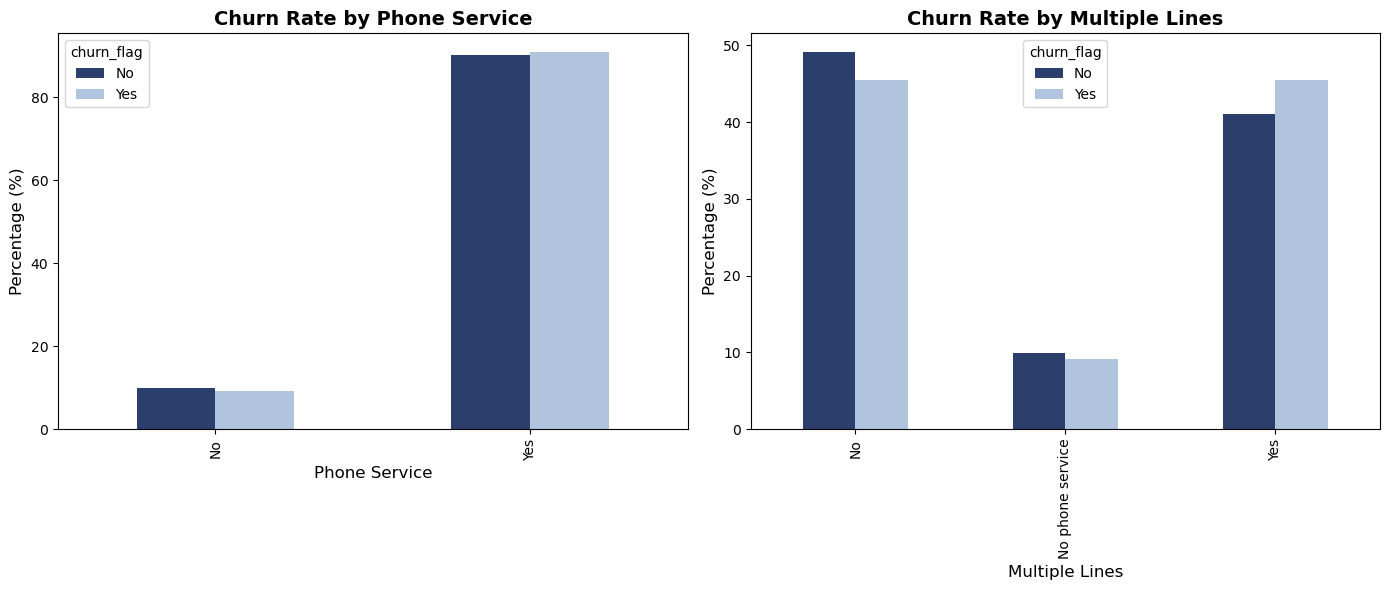

In [8]:
# Phone service columns to analyze
columns = ['Phone Service', 'Multiple Lines']

# Create subplots
fig, axes = plt.subplots(1, len(columns), figsize=(14, 6))

# Loop through columns
for idx, (col) in enumerate(columns):
    # Calculate crosstab with percentages
    crosstab = pd.crosstab(df[col], df['churn_flag'], normalize='columns') * 100

    # Create horizontal bar plot
    crosstab.plot(kind='bar', ax=axes[idx], color=two_palette[:len(crosstab.columns)])

    # Set titles and labels
    axes[idx].set_title('Churn Rate by ' + col, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=12)
    axes[idx].set_ylabel('Percentage (%)', fontsize=12)

plt.tight_layout()
plt.show()

Neither *Phone Service* nor *Multiple lines* seem to affect churn by a reasonable amount, and so can be disregarded as potential impactors of churning.

### v. Tenure

It is also important to review *tenure duration* with respect to churn rate, to analyse how customers churning changes with time spent with the service.

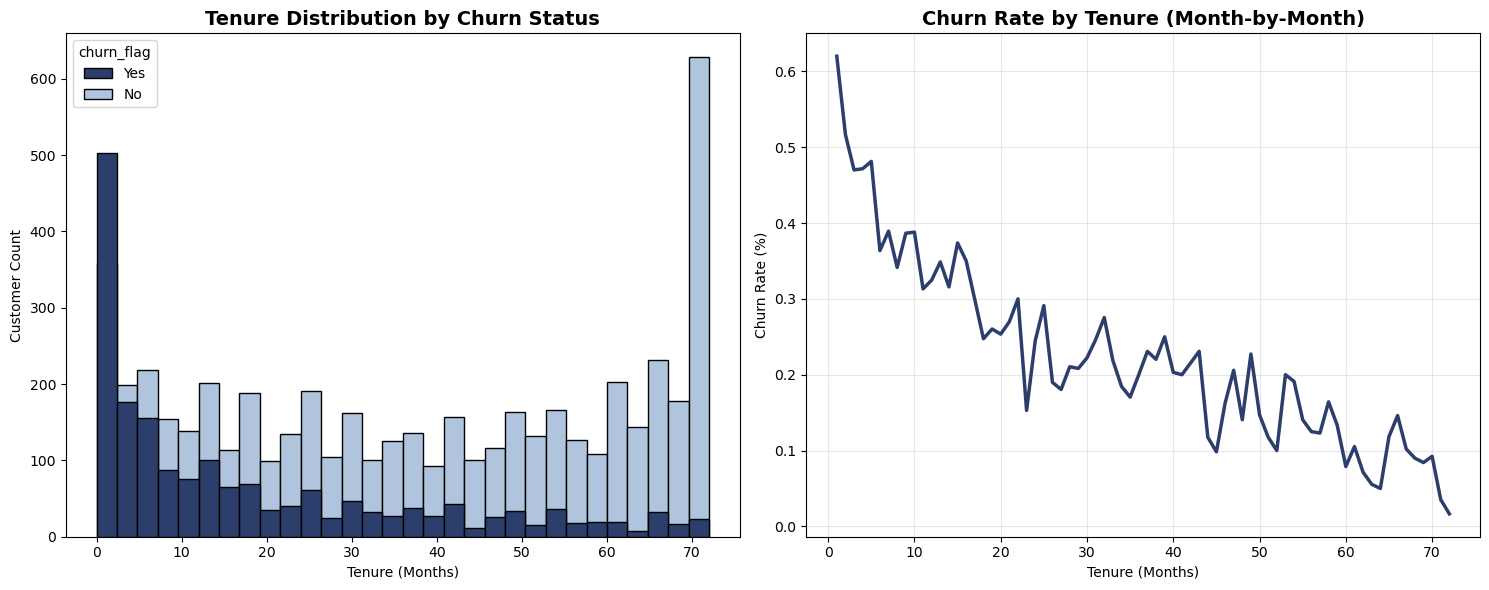

In [9]:
# Tenure Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LHS
sns.histplot(
    data=df,
    x='tenure_months',
    hue='churn_flag',
    bins=30,
    ax=axes[0],
    palette=two_palette,
    alpha=1
)
axes[0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tenure (Months)')
axes[0].set_ylabel('Customer Count')

# RHS
tenure_month_churn = (
    df.groupby('tenure_months')['churn_value']
    .mean()
    .reset_index()
    .rename(columns={'churn_value': 'churn_rate'})
)
tenure_month_churn = tenure_month_churn[tenure_month_churn['tenure_months'] > 0]
sns.lineplot(
    data=tenure_month_churn,
    x='tenure_months',
    y='churn_rate',
    ax=axes[1],
    color='#2c3e6c',
    linewidth=2.5
)
axes[1].set_title('Churn Rate by Tenure (Month-by-Month)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tenure (Months)')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

As seen from the graphs *'Tenure'* is another defining factor. Churn risk is highest during the 
first few months, declining sharply afterwards.

Swan Teleco's customers who remain beyond their first month are significantly less likely to churn.

### 1.3. Churn Drivers
Investigate the top reasons that led customers to churn

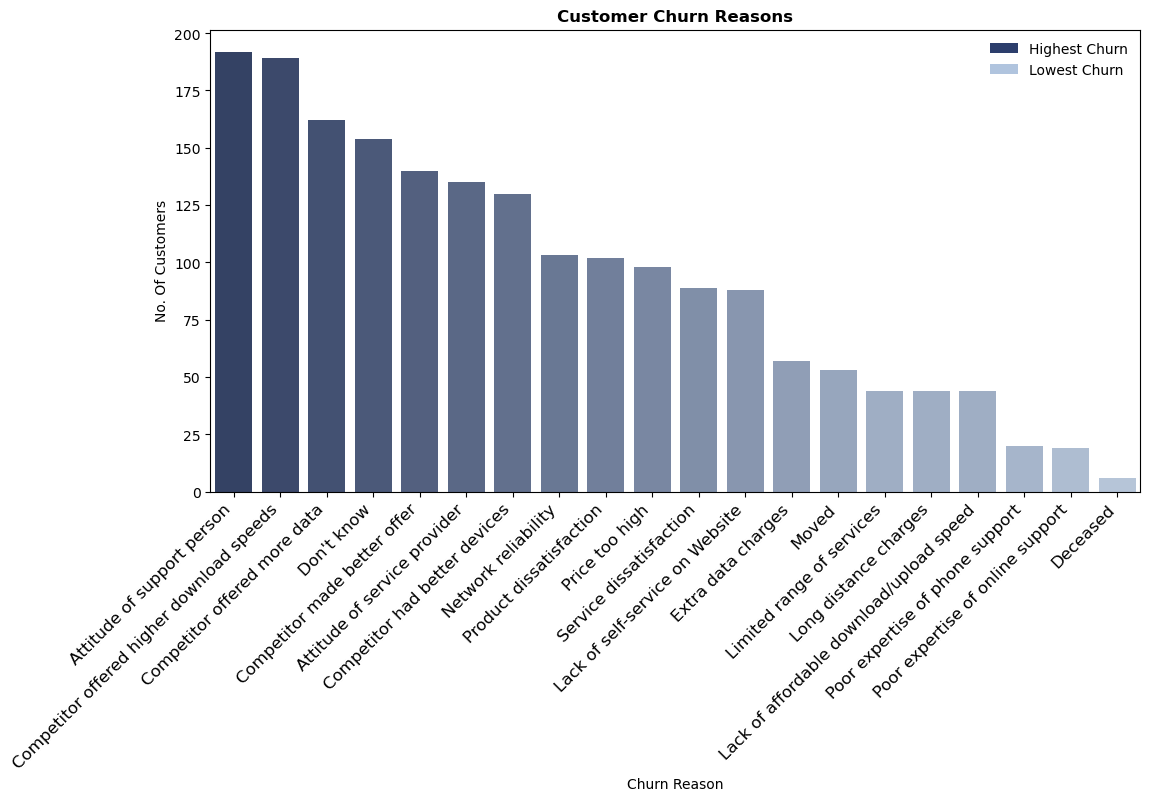

In [10]:
# Graphing the top reasons customers gave for churning

# Convert hex to RGB tuples
start_rgb = to_rgb(five_palette[1])
end_rgb = to_rgb(five_palette[0])

# Create a custom palette by interpolating between the two
n_colors = 18  # Number of colors in the palette
palette = [
    (
        start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (n_colors - 1),
        start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (n_colors - 1),
        start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (n_colors - 1)
    )
    for i in range(n_colors)
]
churnValue_Reason = df[['churn_value', 'churn_reason']]
churnValue_Reason
churned = churnValue_Reason[churnValue_Reason['churn_value'] == 1]
reasonCounts = churned.value_counts()
reasonCounts = pd.DataFrame(reasonCounts).reset_index().rename(columns={'index': 'churn_reason', 0: 'Count'})
reasonCounts
plt.figure(figsize=(12,6))
sns.barplot(x=reasonCounts['churn_reason'], y=reasonCounts['count'], palette=palette, hue = reasonCounts['count'])
plt.xlabel('Churn Reason')
plt.xticks(rotation= 45, # rotating labels
           horizontalalignment = 'right', # aligning them with the bars
           fontweight = 'light',
           fontsize = 'large' # setting the fonts
          )
plt.ylabel('No. Of Customers')
plt.title('Customer Churn Reasons', fontweight='bold')
# Create custom legend with first and last colors
legend_elements = [
    Patch(facecolor=palette[-1], label='Highest Churn'),
    Patch(facecolor=palette[0], label='Lowest Churn')
]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), frameon=False)
plt.show()

Top reasons customers provided by customers for leaving Swan Teleco are:

- Disappointing attitude from customer support.
- Competitive offers providing a better a deal for the user.


Having gathered this insight, let's build a correlation of different features to *churn_value* 
- A negative correlation implies a feature that pushes customers to stay and,
- A positive correlation being a feature that does the opposite.

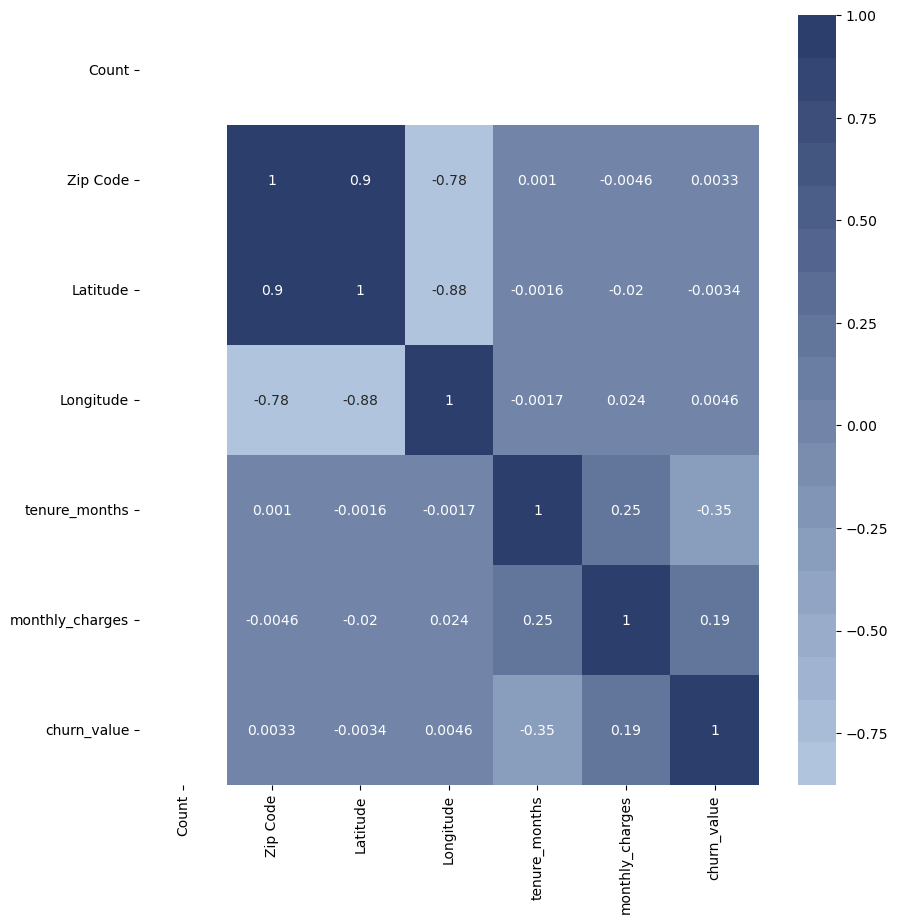

In [11]:
# Creating correlation to see what factors have a negative correlation with churn value.
plt.figure(figsize = (10,10))
sns.heatmap(data = df.corr(numeric_only = True),
            cmap = palette,
            annot = True)
plt.show()

It can be seen that for the target variable of *churn_value*:
- There is a noticeable, negative correlation for *tenure_months*, implying that it correlates to a customer not churning.
- *monthly_charges* have a positive correlation, implying that a higher value here can lead to a customer churning. This feature is also directly linked to the previously mentioned *month to month* contracts.

In [12]:
# Creating churn rate summary table
def churn_rate_summary_fixed(df, features, churn_col='churn_flag'):
    """
    Creates a table with churn % for 'Yes' and 'No' values and Δ%.
    Handles columns with 'No internet service' or 'No phone service'.
    """
    results = []

    df_local = df.copy()

    # Normalize "No internet service"/"No phone service" → "No"
    df_local = df_local.replace({
        'No internet service': 'No',
        'No phone service': 'No'
    })

    for col in features:
        if col not in df_local.columns:
            continue

        churn_table = (
            df_local.groupby(col)[churn_col]
            .apply(lambda x: (x == 'Yes').mean() * 100 if df[churn_col].dtype == 'object' else x.mean() * 100)
        )

        yes_rate = churn_table.get('Yes', np.nan)
        no_rate  = churn_table.get('No', np.nan)
        delta    = yes_rate - no_rate if (not np.isnan(yes_rate) and not np.isnan(no_rate)) else np.nan

        results.append({
            'Feature': col,
            'Churn % (Yes)': round(yes_rate, 2) if not np.isnan(yes_rate) else None,
            'Churn % (No)': round(no_rate, 2) if not np.isnan(no_rate) else None,
            'Δ % (Yes - No)': round(delta, 2) if not np.isnan(delta) else None
        })

    return pd.DataFrame(results).sort_values(by='Δ % (Yes - No)', ascending=False).reset_index(drop=True)


# Include both demographics & service features
features = [
    'Paperless Billing', 'Phone Service', 'Multiple Lines',
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]

summary_table = churn_rate_summary_fixed(df, features)
summary_table

,Feature,Churn % (Yes),Churn % (No),Δ % (Yes - No)
0,Paperless Billing,33.57,16.33,17.24
1,Streaming TV,30.07,24.33,5.74
2,Streaming Movies,29.94,24.38,5.56
3,Multiple Lines,28.61,25.02,3.59
4,Phone Service,26.71,24.93,1.78
5,Device Protection,22.50,28.65,-6.15
6,Online Backup,21.53,29.17,-7.64
7,Tech Support,15.17,31.19,-16.02
8,Online Security,14.61,31.33,-16.72


The summary table provide the delta difference between the churn rates for several important features, as well as providing a strong figure to include within our information deck. Here, a positive value implies that it is a feature that can be seen to lead customers to churn, and the opposite for features with a negative difference.

### Exploratory Data Analysis Conclusion
To summarise our primary findings from our EDA, we conclude that:
* In regards to demographics, the main takeaways are that *senior citizens* are the primary area for concern in regards to a higher churn rate.
* Customers who have *Fibre Optic*, as well as ones who are under a *month to month contract* are both likely to churn and may need incentives to stay.
* Tech add ons such as *Online Security* and *Backup* all seem to be effective to reduce churn, whilst streaming add ons do not have much of an impact.
* The primary reasons given by customers for churning came down to *disappointment in customer support*, or better offerings from competitors. 

## 2. Modelling Churn Risk
Building different models to select the best that can help make the most reliable prediction of customers with their potential risk of churning.

This involves the following steps:
* Feature engineering non-numerical features
* Dropping features not used in modelling
* Splitting the data into a training and testing set to evaluate performace accurately
* Filling missing values
* Scaling the data
* Train a random forest model
* Train a logistic regression model
* Calculate some metrics to compare the models
* Select best on accuracy & f1 score 

### 2.1. Feature Engineering
Feature Engineering using mapping and OHE to relevant columns to make the data numerical for modelling.

In [13]:
# Feature engineering function, maps binary columns to integers (0 and 1)
def feature_engineering(df):
    df_local = df.copy()

    # Convert gender to numeric
    df_local['Gender'] = df_local['Gender'].map({'Male': 0, 'Female': 1})

    # Binary yes/no features
    fe_list = ['Senior Citizen', 'Partner', 'Dependents',
               'Phone Service', 'Paperless Billing']
    for feature in fe_list:
        if feature in df_local.columns:
            df_local[feature] = df_local[feature].map({'No': 0, 'Yes': 1})

    # Internet-related categorical features (one-hot encode)
    internet_list = [
        'Online Security', 'Online Backup', 'Device Protection',
        'Tech Support', 'Streaming TV', 'Streaming Movies', 'Internet Service',
        'Contract', 'Payment Method'
    ]
    df_local = pd.get_dummies(
        data=df_local,
        columns=internet_list,
        drop_first=True,
        dtype='int'
    )

    # Multiple Lines mapping
    if 'Multiple Lines' in df_local.columns:
        df_local['Multiple Lines'] = df_local['Multiple Lines'].map({
            'No': 0,
            'Yes': 1,
            'No phone service': 0
        })

    return df_local

df_eng = feature_engineering(df)

In [14]:
# Extract any features that are objects to avoid mislabelling them, along with the target
drop_cols = [
    'Country',
    'State',
    'City',
    'Zip Code',
    'Lat Long',
    'Latitude',
    'Longitude',
    'customer_id',
    'churn_flag',
    'churn_value',
    'churn_reason',
    'Internet Service',
    'Contract',
    'Tenure Group',
    'Count'
    'churn_risk',
    'churn_risk_log'
    ]
# Create feature matrix X by dropping specified columns from the engineered dataframe
X = df_eng.drop(columns=drop_cols, errors='ignore')
# Define target variable y as the churn_value column
y = df_eng['churn_value']

### 2.2. Split the data

To evaluate model performance reliably, the dataset is divided into training and testing subsets.
The training set is used to fit the models, while the test set provides an unbiased assessment of how well the model generalises to unseen data. 

In [15]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2.3. Fill missing values
Missing values in *total_charges* are imputed with the column median.  
This preserves the variable’s distribution and prevents data loss while avoiding bias from extreme values.

In [16]:
### Fill missing values
median = X_train.loc[~(X_train['total_charges'] == ' ')]['total_charges'].astype('float').median() # Calculate the median 'total_charges' of the non 'empty' values in our training data
print(f'The median value of total charges is {median}')  # Display the median
X_train['total_charges'] = X_train['total_charges'].replace({' ': median}) # Replace the empty values with the median
X_test['total_charges'] = X_test['total_charges'].replace({' ': median}) # same but with test data

The median value of total charges is 1388.0


### 2.4. Scale the data
Numerical features like *tenure*, *monthly_charges*, and *total_charges* are standardised to ensure all variables contribute equally during training.  
This prevents large-valued features from dominating and improves model stability and convergence.

In [17]:
scaler = StandardScaler()
# Fit our scaler on training data, and then transofrm our training data
X_train_scaled = scaler.fit_transform(X_train)
# Transofrm the testing data, using the scaling from the **Training** data
X_test_scaled = scaler.transform(X_test)

### 2.5. Define an evaluation function
Create function to calculate metric scores, will be reused for multiple models

In [18]:
## There are 4 main metrics we're interested in at this stage:
#accuracy, precision, recall and F1.
## The 'metrics' module from sklearn covers all of them (and more!)
#So we can use a function like the one below

def get_results(actual, predicted):
    print("\nResults:\n")
    print("The confusion matrix for your predictions is:")
    print(confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {recall_score(actual, predicted)}')
    print(f'The precision of your model is: {precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {f1_score(actual, predicted)}')

### 2.6. Train the Random Forest Model
**Note**: We investigated using Yggdrasil Decision Forests (YDF), however found due to version incompatibility issues (requires python version pre 3.12), it wasn't feasible to implement it as a working model.

In [19]:
# Random Forest
# rf = RandomForestClassifier(n_estimators = 50)
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced', None]
# }
# gs = GridSearchCV(rf, param_grid, cv=5)
# gs.fit(X_train_scaled, y_train)
# print(gs.best_score_)

# gs.best_params_
# ^- the above piece of code generated the following parameters as optimal, but is excluded due to its slightly lengthy runtime of ~1 minute
rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, max_features = 'sqrt', min_samples_split = 5)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluation
get_results(y_test, y_pred)
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Results:

The confusion matrix for your predictions is:
[[913  96]
 [184 216]] 

The accuracy of your model is: 0.801277501774308
The recall of your model is: 0.54
The precision of your model is: 0.6923076923076923
The F1-score of your model is: 0.6067415730337079
ROC AUC: 0.8549194747274529


To reduce false negatives given by our model, we iterate through testing different thresholds to see whether the model benefits from other common thresholds used and to improve our recall score.

In [20]:
# Get probability predictions for the positive class
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

# Define a range of threshold values to test
thresholds = np.arange(0.2, 0.6, 0.05)
# Evaluate model performance at different threshold values
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Threshold: {threshold:.2f} | Accuracy: {accuracy:.3f}  | Recall: {recall:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")

best_threshold = 0.3  # Chosen heuristically as the best compromise between a high recall and high accuracy.

# Generate final predictions using the selected threshold
y_pred_high_recall = (y_pred_proba >= best_threshold).astype(int)

Threshold: 0.20 | Accuracy: 0.725  | Recall: 0.882 | Precision: 0.509 | F1: 0.646
Threshold: 0.25 | Accuracy: 0.747  | Recall: 0.833 | Precision: 0.535 | F1: 0.651
Threshold: 0.30 | Accuracy: 0.771  | Recall: 0.767 | Precision: 0.572 | F1: 0.655
Threshold: 0.35 | Accuracy: 0.784  | Recall: 0.710 | Precision: 0.602 | F1: 0.651
Threshold: 0.40 | Accuracy: 0.795  | Recall: 0.650 | Precision: 0.636 | F1: 0.643
Threshold: 0.45 | Accuracy: 0.801  | Recall: 0.598 | Precision: 0.666 | F1: 0.630
Threshold: 0.50 | Accuracy: 0.801  | Recall: 0.540 | Precision: 0.692 | F1: 0.607
Threshold: 0.55 | Accuracy: 0.798  | Recall: 0.465 | Precision: 0.724 | F1: 0.566


The threshold of 0.3 has a strong positive effect on the recall whilst not sacrificing the accuracy score too greatly. Thus, the model is reviewed fully when it is given a threshold of 0.3.


Results:

The confusion matrix for your predictions is:
[[779 230]
 [ 93 307]] 

The accuracy of your model is: 0.7707594038325053
The recall of your model is: 0.7675
The precision of your model is: 0.5716945996275605
The F1-score of your model is: 0.655282817502668
ROC AUC: 0.8549194747274529


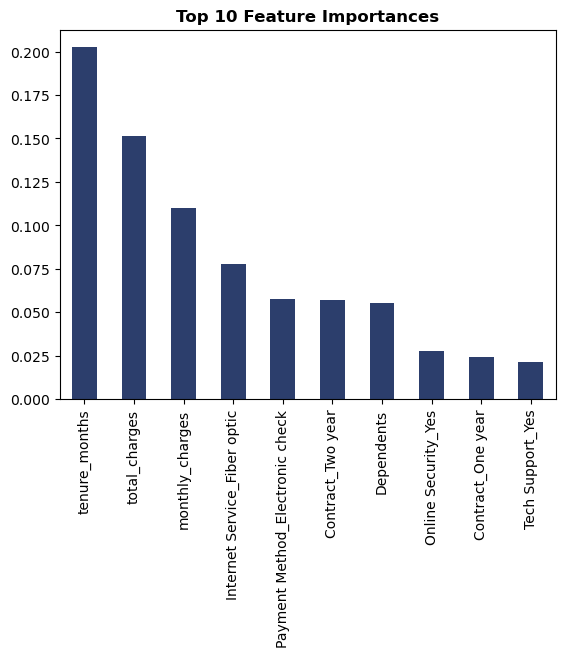

In [21]:
# Predictions
y_prob = rf.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)
# Evaluation
get_results(y_test, y_pred)
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances[:10].plot(kind='bar', color='#2c3e6c')
plt.title("Top 10 Feature Importances", fontweight='bold')
plt.show()

This is the feature importance graph, it shows the features that the model values most.

Notice that tenure months and the two charges columns are the most significant. This makes sense from our EDA, the total_charges is likely to be strongly correlated with the tenure_months.

### 2.7. Train Logistic Regression 

Repeat the same process for a Logistic Regression model to compare performance metrics

In [22]:
# Logistic Regression

# Initialise a log reg model
log_reg = LogisticRegression(max_iter=1000)

param_grid = [
    {'penalty': ['l2'], 'solver': ['lbfgs', 'newton-cg', 'saga'], 'C': [0.01, 0.1, 1, 10]},
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10]}
]

# This is a set of paramater combinations to check which gives the highest paramater, note that some solvers only work
# with specific penalty's hence the two dictionaries given

# Perform the Grid Search aiming to maximise accuracy
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Fit a model with our found parameters
grid_search.fit(X_train_scaled, y_train)
# Generate some predictions
y_pred_log = grid_search.predict(X_test_scaled)

# Generate the probabilities associated with the predictions
y_prob_log = grid_search.predict_proba(X_test_scaled)[:, 1]

# Evaluation
get_results(y_test, y_pred_log)
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))


Results:

The confusion matrix for your predictions is:
[[900 109]
 [169 231]] 

The accuracy of your model is: 0.8026969481902059
The recall of your model is: 0.5775
The precision of your model is: 0.6794117647058824
The F1-score of your model is: 0.6243243243243243
ROC AUC: 0.8539358275520318


Similar to the Random Forest model, we iterate through thresholds to see how it performs with different classifications.

In [23]:
# Get probability predictions for the positive class
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:, 1]

thresholds = np.arange(0.2, 0.6, 0.05)

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Threshold: {threshold:.2f} | Accuracy: {accuracy:.3f}  | Recall: {recall:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")

# Chosen heuristically as the best compromise between a high recall and high accuracy.
best_threshold = 0.3
y_pred_high_recall = (y_pred_proba >= best_threshold).astype(int)

Threshold: 0.20 | Accuracy: 0.727  | Recall: 0.875 | Precision: 0.511 | F1: 0.645
Threshold: 0.25 | Accuracy: 0.746  | Recall: 0.823 | Precision: 0.534 | F1: 0.648
Threshold: 0.30 | Accuracy: 0.766  | Recall: 0.760 | Precision: 0.565 | F1: 0.648
Threshold: 0.35 | Accuracy: 0.784  | Recall: 0.723 | Precision: 0.600 | F1: 0.655
Threshold: 0.40 | Accuracy: 0.792  | Recall: 0.682 | Precision: 0.622 | F1: 0.651
Threshold: 0.45 | Accuracy: 0.797  | Recall: 0.627 | Precision: 0.647 | F1: 0.637
Threshold: 0.50 | Accuracy: 0.803  | Recall: 0.578 | Precision: 0.679 | F1: 0.624
Threshold: 0.55 | Accuracy: 0.798  | Recall: 0.495 | Precision: 0.707 | F1: 0.582


The same adjusted threshold of 0.3 is chosen for the sake of consistency in both models.

In [24]:
# Predictions
y_prob = grid_search.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob >= best_threshold).astype(int)
# Evaluation
get_results(y_test, y_pred)
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Results:

The confusion matrix for your predictions is:
[[775 234]
 [ 96 304]] 

The accuracy of your model is: 0.765791341376863
The recall of your model is: 0.76
The precision of your model is: 0.5650557620817844
The F1-score of your model is: 0.6481876332622601
ROC AUC: 0.8539358275520318


### 2.8. Train a Support Vector Machine (SVM) Model

Finally test a SVM and once again compare performance metrics

In [25]:
from sklearn import svm

svm_model = svm.SVC()

param_grid = [
    {'C': [0.01, 0.1, 1, 10]}
]

# This is a set of paramater combinations to check which gives the highest para
# Perform the Grid Search aiming to maximise accuracy
svm_grid = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
# Fit a model with our found parameters
svm_grid.fit(X_train_scaled, y_train)

# Generate some predictions
y_pred_svm = svm_grid.predict(X_test_scaled)

# Evaluation
get_results(y_test, y_pred_svm)
print("ROC AUC:", roc_auc_score(y_test, y_pred_svm))


Results:

The confusion matrix for your predictions is:
[[920  89]
 [181 219]] 

The accuracy of your model is: 0.808374733853797
The recall of your model is: 0.5475
The precision of your model is: 0.711038961038961
The F1-score of your model is: 0.6186440677966102
ROC AUC: 0.7296469276511397


### 2.9. Compare our Three Models

The models have produced very similar results, as can be seen below.

| Model                     | Threshold | Accuracy | Recall  | Precision | F1-Score | ROC AUC |
|----------------------------|------------|-----------|----------|------------|-----------|----------|
| **Random Forest**          | 0.5        | 0.8034    | 0.5450   | 0.6965     | 0.6115    | 0.8551   |
| **Random Forest**          | 0.3        | 0.7622    | 0.7725   | 0.5588     | 0.6485    | 0.8551   |
| **Logistic Regression**    | 0.5        | 0.8027    | 0.5775   | 0.6794     | 0.6243    | 0.8539   |
| **Logistic Regression**    | 0.3        | 0.7658    | 0.7600   | 0.5651     | 0.6481    | 0.8539   |
| **Support Vector Machine** | n/a        | 0.8084    | 0.5475   | 0.7110     | 0.6186    | 0.7296   |

From these, we chose to use Random Forest with a threshold of 0.3 as our final model, due to having the highest recall score. This relates to the least amount of false negatives, so we are not predicting customers likely to churn to not churn.

**Note**: The change in threshold does not affect the lists produced, as those state the exact probabilities, labelled as *churn risk*.

## 3. Extracting the customer list

The better model (Random Forest) has been used to create the two lists of customers: 'Top 500 customers likely to churn' as well as 'predictions of all customers likely to churn' for the customer support team. 

**Note**: The conscious choice is made to only include the *customer ID* within the list of 'Top 500 customers likely to churn' as a form of abstraction to ensure that only the information necessary for the mailing list is given.

In [26]:
# Store ids for later
ids = df_eng[['customer_id', 'churn_flag']]
# Drop columns so that we are using training columns
X_final =df_eng.drop(columns=drop_cols, errors='ignore').copy()
# Fill values with the mean of our training data
X_final['total_charges'] = X_final['total_charges'].replace({' ': median})
# Scale the values using the scaler we used for our training data
X_final = scaler.transform(X_final)

# Add a column to our dataframe with the churn risk probability according to our chosen model (random forest)
df_eng['churn_risk'] = rf.predict_proba(X_final)[:, 1]
# Same thing with logisitic regression model
df_eng['churn_risk_log'] = grid_search.predict_proba(X_final)[:, 1]
# Sort values by risk
sorted_by_rf = df_eng.sort_values(by = 'churn_risk', ascending=False)
# Sort values by risk
sorted_by_log = df_eng.sort_values(by = 'churn_risk_log', ascending=False)

In [27]:
# Select just the customers who haven't churned
non_churners = sorted_by_rf.loc[sorted_by_rf['churn_flag'] == 'No']

# Extract just the ids of the top 500 customers
top_500_customers = non_churners[['customer_id']].iloc[ :500, : ]

if top_500_customers['customer_id'].nunique() == 500:
    print("Top 500 customers list check passed: 500 unique customer IDs.")
else:
    print("Top 500 customers list check failed")
# Save that list as a csv
top_500_customers.to_csv("top_500_customers.csv", index=False)

Top 500 customers list check passed: 500 unique customer IDs.


In [28]:
# Select relevent columns of non churners
customer_risk_list = non_churners[['customer_id', 'churn_risk']]
expected = non_churners.shape[0]
actual = customer_risk_list.shape[0]

if actual == expected:
    print(f"Customer risk list check passed: {actual} customers (all non-churners).")
else:
    print("Customer risk list check failed")
if pd.api.types.is_numeric_dtype(customer_risk_list['churn_risk']):
    print("churn_risk column is numeric.")
else:
    print("churn_risk column numeric check failed")

customer_risk_list.to_csv("customer_churn_risk.csv", index=False)  # Save as a csv

Customer risk list check passed: 5174 customers (all non-churners).
churn_risk column is numeric.
